# TP7 - PCA: Principal Component Analysis 

**Alumna**: Lucia Berard

**Fecha**: 18/05/2025


[Link a Google Colab](https://colab.research.google.com/drive/1ah4GT2vGlptvJM9qctPRs0NpqqozR07z?usp=sharing)

La base de datos FASHION-MNIST posee imágenes de diferentes prendas de vestir, pertenecientes a 10 clases diferentes. Se desea entrenar un algoritmo de PCA.

___
## (a) Base de datos

Cargar la base de datos utilizando `tensorflow.keras.datasets.fashion_mnist.load_data`. Utilizando `imshow` (matplotlib) represente 10 muestras del conjunto de testeo elegidas al azar. ¿Qué tipo de prenda representa cada categoría?

Siguiendo la documentacion de [`fashion_mnist`](https://www.tensorflow.org/datasets/catalog/fashion_mnist), la funcion devuelve:
```python
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
````

donde:

- x_train: imágenes de entrenamiento, forma (60000, 28, 28)
- y_train: etiquetas asociadas, forma (60000,)
- x_test: imágenes de testeo, forma (10000, 28, 28)
- y_test: etiquetas de testeo, forma (10000,)

Las imágenes son en escala de grises, valores enteros de 0 a 255 (uint8). Las etiquetas son enteros de 0 a 9, indicando la clase de la prenda (t-shirt, trouser, etc.). 

De la documentación oficial en github se obtuvo los valores de `label_names`. (Ver https://github.com/zalandoresearch/fashion-mnist?tab=readme-ov-file#labels )

In [12]:
%pip install --upgrade tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist, mnist
from sklearn.metrics import roc_curve, auc



You should consider upgrading via the '/Users/luberard/Documents/fiuba/taller-procesamiento-tde/venv-taller/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


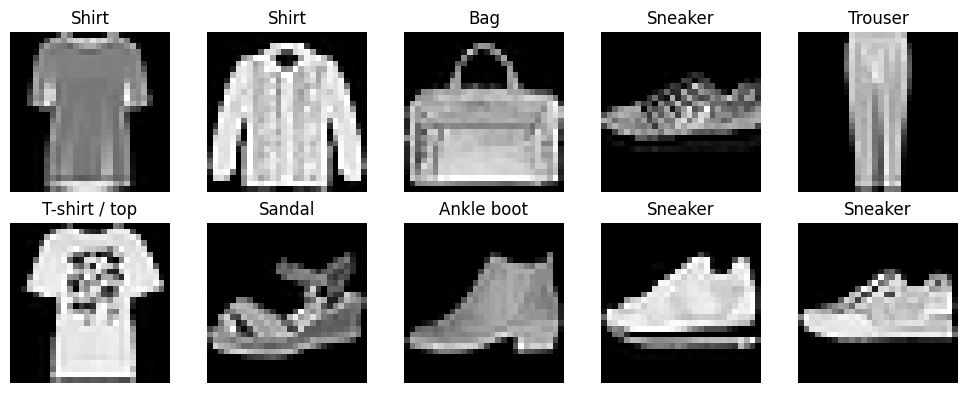

,Etiqueta,Prenda
0,0,T-shirt / top
1,1,Trouser
2,2,Pullover
3,3,Dress
4,4,Coat
5,5,Sandal
6,6,Shirt
7,7,Sneaker
8,8,Bag
9,9,Ankle boot


In [ ]:
# Cargar los datos
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Diccionario de etiquetas
label_names = {
    0: "T-shirt / top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Selección de 10 imágenes random del conjunto de test
indices = np.random.choice(len(x_test), size=10, replace=False)
samples = x_test[indices]
sample_labels = y_test[indices]

# Visualización de las imágenes
plt.figure(figsize=(10, 4))
for i, (img, lbl) in enumerate(zip(samples, sample_labels)):
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(label_names[lbl])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Tabla de etiquetas
df_labels = pd.DataFrame.from_dict(label_names, orient='index', columns=['Prenda'])
df_labels.index.name = 'Etiqueta'
df_labels.reset_index(inplace=True)

df_labels


___
## (b)

Implementar el algoritmo de PCA utilizando `linalg.eig` (numpy). El código debe estar estructurado de la siguiente manera (implementar todos los métodos mencionados):

```python
class PCA:

    # Inicializar atributos y declarar hiperparámetros. No aclarar aún la dimensión
    # del espacio latente
    def __init__(self,...):

    # Etapa de entrenamiento. Se entrenan todos los autovectores, sin definir la
    # dimensión latente
    def fit(self,X):

    # Transformar del espacio original al espacio latente de dimensión k.
    def transform(self,X,k):

    # Transformar del espacio latente al espacio original
    def inverse_transform(self,U):

    # fit + transform
    def fit_transform(self,X,k):

    # transform + inverse_transform. Debe incluir la posibilidad de aprovechar
    # reconstrucciones ya efectuadas con menos cantidad de componentes.
    def transform_reconstruction(self,X,k,use_previous_results = False):

    # fit + transform_reconstruction. No es necesario utilizar resultados
    # anteriores pues entrenamiento hay uno solo.
    def fit_reconstruction(self,X,k):
```


**Pasos para implementar PCA**

1. Centrar los datos: hay que restar a cada variable su media para que queden con media cero. Esto asegura que el primer componente capture la dirección de máxima varianza real del dato (y no de un offset)

$$
X_c = X - \mu 
$$

$$
\mu_{j} = \frac{1}{n}\sum^{n}_{i=1}X_{ij} 
$$

2. Matriz de covarianza: Se calcula como
$$
\sum = \frac{1}{n}X_c^TX_c
$$

3. Descomposicion en valores y vectores propios: Se puede usar [numpy.linalg.eig](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) para obtener la ecuacion, donde cada $\lambda_i$ es un autovalor de $v_i$ el autovector asociado: 
$$
\sum v_i = \lambda v_i
$$
 

4. Ordenar componentes: Se ordenan los autovalores $\lambda_{1} ≥ \lambda_{2} ... ≥ \lambda_{d} $ y sus vectores correspondientes.
5. Proyeccion (transform)
6. Reconstruccion (inverse_transform)

Datos en cuanto al codigo:
- `mean_`: vector de medias de cada feature
- `components_`: matriz de autovectores ordenados de mayor a menor varianza
- `explained_variance_`: autovalores ordenados de mayor a menor.
- `_last_k`: Último número de componentes usado en reconstrucción incremental.
- `_last_reconstruction`: Última reconstrucción calculada (para uso incremental).


In [ ]:

class PCA:
    def __init__(self, center: bool = True):
        """
        center: si True, resta la media de cada feature antes de calcular la PCA.
        """
        self.center = center
        self.mean_ = None            # vector de medias
        self.components_ = None      # matriz V de autovectores (d×d)
        self.explained_variance_ = None  # autovalores λ
        # Para reconstrucción incremental
        self._last_k = 0
        self._last_reconstruction = None

    def fit(self, X: np.ndarray):
        """
        Ajusta la PCA calculando todos los autovectores/autovalores de la covarianza.
         X : Matriz de datos de entrenamiento.

        - Centra los datos (si self.center=True), calcula Σ=(1/n) XᵀX,  
        y obtiene la descomposición espectral con numpy.linalg.eig.  
        - Reinicia el estado de reconstrucción incremental.
        """
        # 1) Centrar
        if self.center:
            self.mean_ = X.mean(axis=0)
            Xc = X - self.mean_
        else:
            self.mean_ = np.zeros(X.shape[1])
            Xc = X.copy()

        # 2) Covarianza
        #    Σ = (1/n) Xc^T Xc
        cov = (Xc.T @ Xc) / Xc.shape[0]

        # 3) Eigen-descomposición
        eigvals, eigvecs = np.linalg.eig(cov)

        # 4) Ordenar de mayor a menor varianza
        idx = np.argsort(eigvals)[::-1]
        self.explained_variance_ = eigvals[idx]
        self.components_ = eigvecs[:, idx]

        # Reiniciar reconstrucción incremental
        self._last_k = 0
        self._last_reconstruction = None

    def transform(self, X: np.ndarray, k: int) -> np.ndarray:
        """
        Proyecta X en el subespacio de dimensión k: U = (X - mean) · V_k.
        """
        Xc = X - self.mean_
        V_k = self.components_[:, :k]  # primeros k vectores
        U = Xc @ V_k
        return U

    def inverse_transform(self, U: np.ndarray) -> np.ndarray:
        """
        Reconstruye datos en el espacio original: X̂ = U · V_k^T + mean.
        """
        k = U.shape[1]
        V_k = self.components_[:, :k]
        X_hat = U @ V_k.T + self.mean_
        return X_hat

    def fit_transform(self, X: np.ndarray, k: int) -> np.ndarray:
        """
        Fit + Transform conjunto X.
        """
        self.fit(X)
        return self.transform(X, k)

    def transform_reconstruction(self, X: np.ndarray, k: int,
                                 use_previous_results: bool = False) -> np.ndarray:
        """
        Transform + inverse_transform, con posibilidad de reutilizar la reconstrucción
        previa para k-1 componentes y añadir sólo la contribución del componente k.
        """
        if not use_previous_results or self._last_reconstruction is None or k <= self._last_k:
            # Computo completo si no se pide incremental o si k no aumentó
            U = self.transform(X, k)
            X_hat = self.inverse_transform(U)
        else:
            # Reconstrucción incremental:
            # X̂_k = X̂_{k-1} + (U[:, k-1] · V[:, k-1]^T)
            # donde U[:, k-1] = (Xc · v_{k-1})
            Xc = X - self.mean_
            v_new = self.components_[:, self._last_k:self._last_k+1]  # vector k-1
            u_new = Xc @ v_new
            contrib = u_new @ v_new.T
            X_hat = self._last_reconstruction + contrib

        # Actualizar estado para posible siguiente incremental
        self._last_k = k
        self._last_reconstruction = X_hat.copy()
        return X_hat

    def fit_reconstruction(self, X: np.ndarray, k: int) -> np.ndarray:
        """
        Fit + transform_reconstruction. No reutiliza resultados anteriores, pues el
        entrenamiento sólo se hace una vez.
        """
        self.fit(X)
        return self.transform_reconstruction(X, k, use_previous_results=False)
    
pca = PCA(center=True)

# Convierto las imágenes (28x 28) en vectores de 784 dimensiones
# Paso a `float` para poder restar/promediar.  
X_train = x_train.reshape(-1, 28*28).astype(float)
X_test  = x_test.reshape(-1, 28*28).astype(float)

pca.fit(X_train)

___
## (c) Porcentaje de energia
Calcular y graficar el porcentaje de energía en función del número de componentes principales.


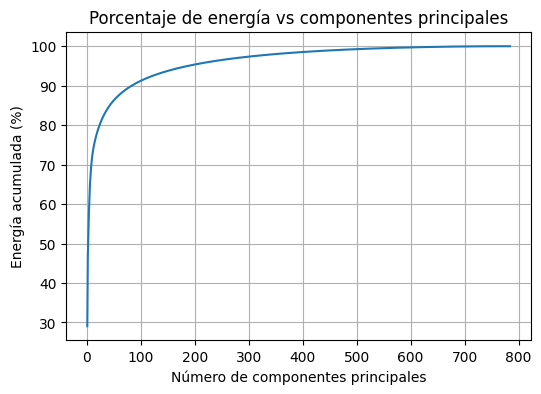

In [16]:
# explained_variance_ guarda los autovalores λ₁,λ₂,… en orden decreciente
eigvals = pca.explained_variance_
total_energy = eigvals.sum()  # suma de todos los λ
percent_energy = np.cumsum(eigvals) / total_energy * 100  # da el porcentaje acumulado de varianza 

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(percent_energy)+1), percent_energy)
plt.xlabel("Número de componentes principales")
plt.ylabel("Energía acumulada (%)")
plt.title("Porcentaje de energía vs componentes principales")
plt.grid(True)
plt.show()


___
## (d) Error cuadrático medio
Graficar el error cuadrático medio de testeo en función del número de componentes principales.

*️⃣ *Mucha atención a no repetir cómputos. Es decir, aprovechar la reconstrucción con k componentes principales para el cálculo de k + 1 componentes. Es importante también que el ECM no se vea afectado por normalizaciones.*


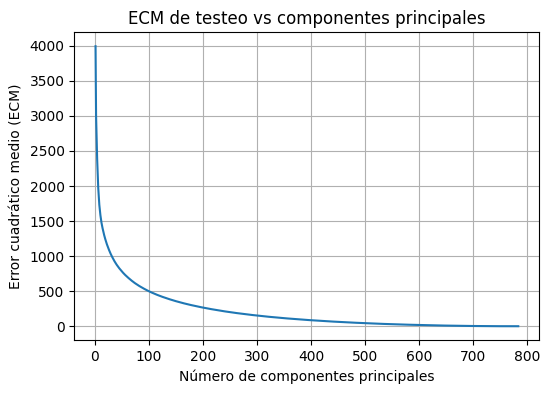

In [17]:
mses = []
# _last_reconstruction se maneja internamente en transform_reconstruction
for k in range(1, X_train.shape[1]+1):
    # Para k=1 fuerza cómputo completo; luego, use_previous_results=True
    use_prev = (k > 1)
    X_hat = pca.transform_reconstruction(X_test, k, use_previous_results=use_prev)
    mse = np.mean((X_test - X_hat)**2)  # ECM = E[(x - x̂)²]
    mses.append(mse)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(mses)+1), mses)
plt.xlabel("Número de componentes principales")
plt.ylabel("Error cuadrático medio (ECM)")
plt.title("ECM de testeo vs componentes principales")
plt.grid(True)
plt.show()


___
## (e) Gráficos imágenes reconstruidas
Graficar 10 imágenes reconstruidas de testeo (elegidas al azar) utilizando 1, 100 y 784 componentes principales.


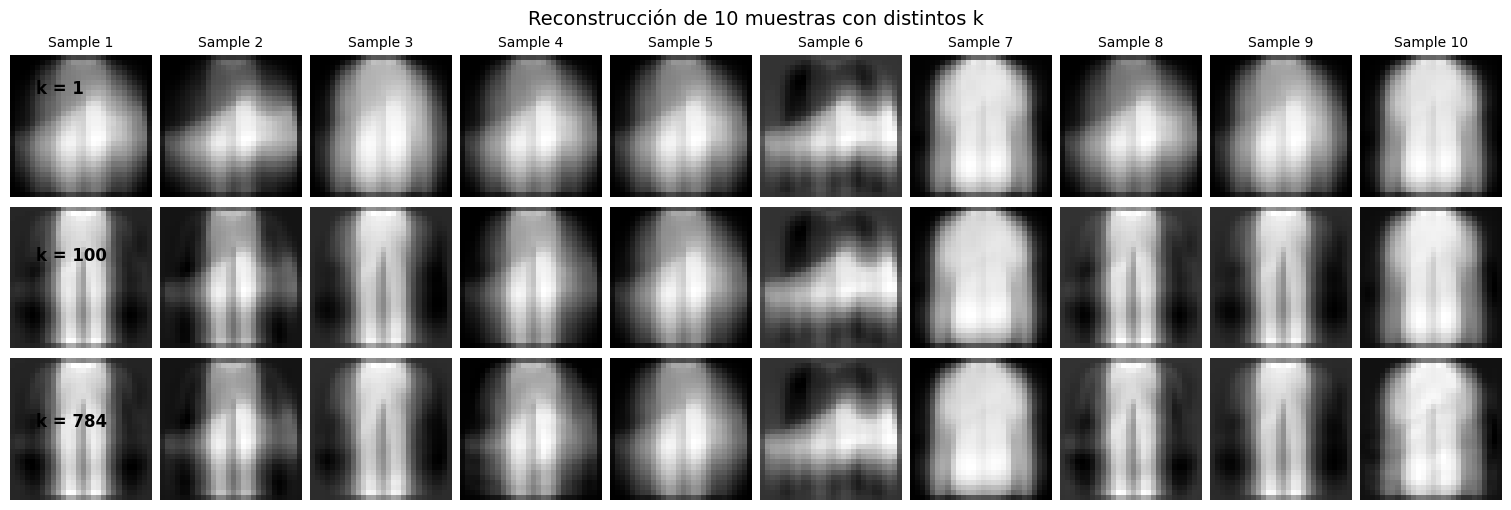

In [ ]:
indices = np.random.choice(X_test.shape[0], size=10, replace=False)
X_samples = X_test[indices]

# Reconstrucciones para k=1,100,784 usando incremental
ks = [1, 100, 784]
recons = {}
for i, k in enumerate(ks):
    # use_previous_results=True a partir de k>1 para añadir solo la contribución extra
    use_prev = (k > ks[0])
    X_hat = pca.transform_reconstruction(X_samples, k, use_previous_results=use_prev)
    recons[k] = X_hat.reshape(-1,28,28)

# Visualización 
fig, axes = plt.subplots(nrows=len(ks), ncols=10, figsize=(15, 5), constrained_layout=True)

# Títulos de columnas
for col in range(10):
    axes[0, col].set_title(f"Sample {col+1}", fontsize=10)

# Mostrar imágenes y anotar cada fila con su k
for row, k in enumerate(ks):
    # Anotación en el margen izquierdo: k = ...
    y_pos = 1 - (row + 0.5) / len(ks)  # coordenada en fracción de figura
    fig.text(0.02, y_pos, f'k = {k}', va='center', ha='left', fontsize=12, weight='bold')
    for col in range(10):
        ax = axes[row, col]
        ax.imshow(recons[k][col], cmap='gray')
        ax.axis('off')

plt.suptitle("Reconstrucción de 10 muestras con distintos k", fontsize=14)
plt.show()

En el grafico se nota como al aumentar el $k$, mejora la calidad de la reconstrucción.


___
## (f) Desempeño como detector de anomalías
Se desea evaluar el desempeño del algoritmo como detector de anomalías. Para ello, construir una base de datos combinando el conjunto de datos de testeo con el conjunto de datos de testeo de la base de datos MNIST (base de datos de imágenes dígitos manuscritos del mismo tamaño). Dicha base de datos puede ser cargada con tensorflow.keras.datasets.mnist.load_data.


In [19]:
# 1) Carga de testeo de ambas bases
(_, _), (X_fashion, _ ) = fashion_mnist.load_data()
(_, _), (X_digits,  _ ) = mnist.load_data()

# 2) Aplanar y pasar a float
X_f = X_fashion.reshape(-1, 28*28).astype(float)
X_m = X_digits .reshape(-1, 28*28).astype(float)

# 3) Etiquetas: 0 = normal (Fashion), 1 = anomalía (MNIST)
y_f = np.zeros(X_f.shape[0], dtype=int)
y_m = np.ones (X_m.shape[0], dtype=int)

# 4) Concatenar y barajar
X_comb = np.vstack([X_f, X_m])
y_comb = np.hstack([y_f, y_m])
perm = np.random.RandomState(0).permutation(len(y_comb))
X_comb, y_comb = X_comb[perm], y_comb[perm]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step



___
## (g)
Diseñar un detector de anomalías comparando el error cuadrático contra un umbral. Implementar y graficar la curva ROC para 1, 100 y 784 componentes principales.



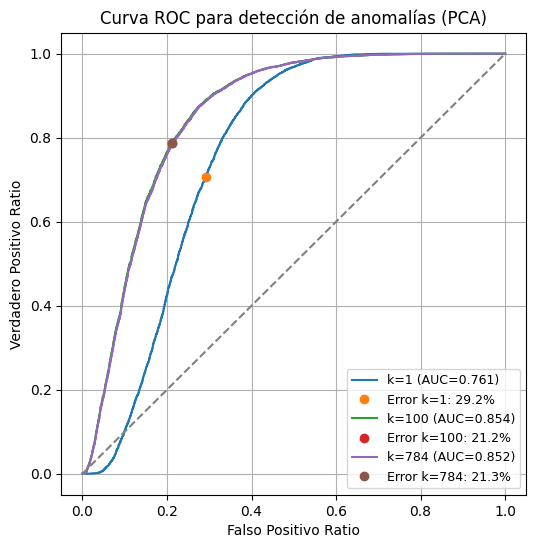

In [21]:
ks = [1, 100, 784]
plt.figure(figsize=(6,6))

for k in ks:
    # 1) Reconstrucción incremental sobre X_comb
    use_prev = (k > ks[0])
    X_hat = pca.transform_reconstruction(X_comb, k, use_previous_results=use_prev)
    # 2) Error cuadrático medio por muestra
    mse = np.mean((X_comb - X_hat)**2, axis=1)
    # 3) Curva ROC
    fpr, tpr, thresholds = roc_curve(y_comb, mse)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             label=f'k={k} (AUC={roc_auc:.3f})')
    # 4) Marcar Error (donde FPR ≈ 1−TPR)
    eer_idx = np.nanargmin(np.abs(fpr + tpr - 1))
    plt.plot(fpr[eer_idx], tpr[eer_idx], 'o',
             label=f'Error k={k}: {(fpr[eer_idx]*100):.1f}%')

# 5) Detalles del gráfico
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('Falso Positivo Ratio')
plt.ylabel('Verdadero Positivo Ratio')
plt.title('Curva ROC para detección de anomalías (PCA)') 
plt.legend(loc='lower right', fontsize=9)
plt.grid(True)
plt.show()

**Curva ROC (True Positive vs False Positive)**

- El eje Y es la tasa de verdaderos positivos (TPR): cuántos dígitos (anomalías) detectas.

- El eje X es la tasa de falsos positivos (FPR): cuántas ropas (normales) clasificas por error como dígitos.

**AUC (Area Under Curve)**

- k = 1 → AUC=0.761: sólo con 1 componente la separación es pobre (AUC próxima a 0.5 sería aleatorio).

- k = 100 → AUC=0.854: muy buena discriminación (cuanto más cerca de 1, mejor).

- k = 784 → AUC=0.852: casi igual que k=100; usar todas las componentes no mejora notablemente.

**Error**
Marca el punto donde FPR ≈ 1–TPR, es decir donde tasa de falsos positivos = tasa de falsos negativos.

- k=1 → EER ≈ 29.2 %

- k=100 → EER ≈ 21.2 %

- k=784 → EER ≈ 21.3 %


**¿Qué significa esto?**

- Pocos componentes (k=1): modelo demasiado simple; reconstruye mal tanto ropas como dígitos, por eso no los separa bien.

- Demasiados componentes (k=784): al usar toda la varianza, también reconstruye bastante bien los dígitos “anómalos”, y la separación deja de mejorar.

- Punto óptimo (k≈100): Captura la mayor parte de la variabilidad de la ropa, pero no la de los dígitos, por lo que el error de reconstrucción de éstos es mucho mayor.
